In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from scipy.optimize import curve_fit
%matplotlib inline



# Import Data

In [ ]:
data= np.loadtxt('lightcurve.dat') #import Kepler data
t,flux,error=(data[1:,0],data[1:,1],data[1:,2])

# Things we know from literature ( Jon Jenkins et al. 2015)
P_literature = 384.843
tau_literature = 54833 + 314.98
T_literature = 10.63/24.0      # literature reported transit duration

# Define a set of test parameters
theta=np.empty([5])
theta[0] = 0.0128          # Rp/Rstar
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter
theta[3] = P_literature    # orbital period
theta[4] = tau_literature  # transit mid-point

In [4]:
#will fold all times to center transit at 0 according to tau literature (Jon Jenkins et al. 2015)
tobsfolded=np.empty([len(t)])
for i in range(len(t)):
    tobsfolded[i]=t[i]-tau_literature-P_literature*np.round((t[i]-tau_literature)/P_literature)

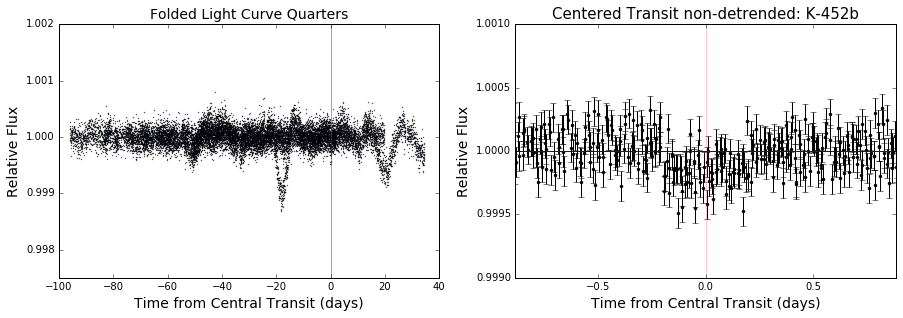

In [7]:
plt.figure(figsize=(15,10))

plt.subplot(221)
plt.scatter(tobsfolded,flux,s=0.1)
plt.axvline(0,color='red',alpha=0.5)
plt.xlabel('Time from Central Transit (days)',size=14)
plt.ylabel('Relative Flux',size=14)
plt.title('Folded Light Curve Quarters',size=14)
plt.xlim(-100,40)

plt.subplot(222)
plt.errorbar(tobsfolded,flux,yerr=error,color='k',fmt='.')
plt.xlim(-2*T_literature,+2*T_literature)
plt.ylim(0.999,1.001)
plt.axhline(1)
plt.axvline(0,color='red',alpha=0.2)
plt.xlabel('Time from Central Transit (days)',size=14)
plt.ylabel('Relative Flux',size=14)
plt.title('Centered Transit non-detrended: K-452b',size=15)

# Define Moving Median (MM) & Remove Outliers (RO)
### Detrending non-parametrically

In [9]:
def m_m(x,window):
    """ Moving Median function --- used to detrend the data non-parametrically."""
    #Define Lists  
    R=[]
    DP=window-1 # accounted for the length of even and uneven numbers. 
    for i in range( len(flux)-DP ):
        MM = x[i:(i+window)] #Jumping indicies -- that allow the moving median
        MED = np.median(np.sort(MM)) #We sort the window and take the median. 
        R.append(MED) #Append list (R)
        
    return R 


def get_out(flux,t,window,error):
    """Get_out ---Identifying accepted points (raw data) and finding outliers."""
    #Define Lits: 
    D1, D2, D3, D4, D5 = [], [], [], [], []
    
    
    for i in range( len(flux)):
        MM = flux[i:(i+window)] #Jumping indicies -- that allow the moving median
        MED = np.median(np.sort(MM)) #Find moving Median of window 
        
        #Decide if data to be accepted or rejected.   
        if np.absolute(flux[i] - MED) > (2.7*error[i]):  #2.7 works well 
            D1.append(flux[i]) #rejected...
            D2.append(t[i])
        else: 
            D3.append(flux[i]) #accepted...
            D4.append(t[i])
            D5.append(error[i]) 

    return D1,D2,D3,D4,D5

def m_m_new(x,window): # note*is the same as m_m
    #Define Lists  
    R=[]
    DP=window
    for i in range( len(x)-DP ):
        MM = x[i:(i+window)] #Jumping indicies
        MED = np.median(np.sort(MM)) #We sort the window and take the median. 
        R.append(MED) #Append list (R)
        
    return R 

# Define : Accepted & Rejected Data

In [10]:
new_set = get_out(flux,tobsfolded,12,error)
#Rejected...
rej_flux = new_set[0]
rej_t = new_set[1]
#Accepted... 
acc_flux = new_set[2]
acc_t = new_set[3]
acc_e = new_set[4]

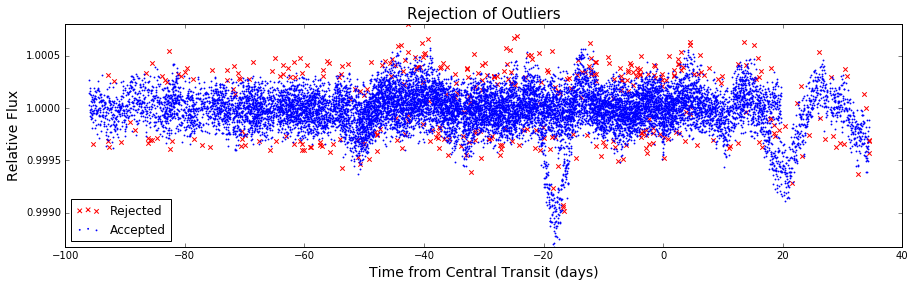

In [12]:
plt.figure(figsize=(15,4))
plt.scatter(rej_t,rej_flux,color='red',marker='x',label='Rejected')
plt.scatter(acc_t,acc_flux,color='blue',s=0.7,label='Accepted')
plt.legend(loc=3)
plt.ylim(min(flux),max(flux))
plt.xlim(-100,40)
plt.xlabel('Time from Central Transit (days)',size=14)
plt.ylabel('Relative Flux',size=14)
plt.title('Rejection of Outliers',size=15)


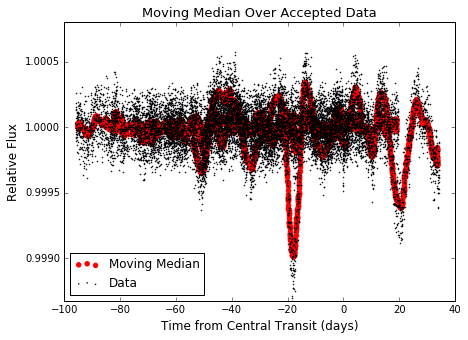

In [15]:
plt.figure(figsize=(7,5))
plt.scatter(m_m_new(acc_t,70),m_m_new(acc_flux,70),color='red',label='Moving Median')
plt.scatter(acc_t,acc_flux,s=0.3,label='Data')
plt.legend(loc=3)
plt.xlim(-100,40)
plt.ylim(min(flux),max(flux))
#plt.xlim(-2*T_literature,+2*T_literature) #transit region!
plt.xlabel('Time from Central Transit (days)',size=12)
plt.ylabel('Relative Flux',size=12)
plt.title('Moving Median Over Accepted Data',size=13)

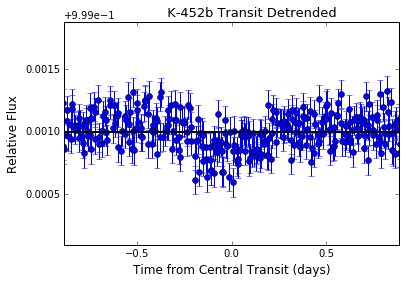

In [16]:
# We attempt to detrend our data non-parametrically

W = 63 #window size 
Div = np.array((acc_flux[W/2:-W/2]))/np.array((m_m_new(acc_flux,W))) #[W/2:-W/2] equally trims data

#Plot
plt.errorbar(acc_t[W/2:-W/2],Div,yerr=acc_e[W/2:-W/2],fmt='o')
plt.xlim(-2*T_literature,+2*T_literature) #transit region
plt.ylim(min(Div)-0.0005,max(Div)+0.0005)
plt.axhline(1,color='k',lw=2)
plt.xlabel('Time from Central Transit (days)',size=12)
plt.ylabel('Relative Flux',size=12)
plt.title('          K-452b Transit Detrended',size=13)

In [17]:
#Theta are our parameters: 
# Define a set of test parameters
theta=np.empty([5])
theta[0] = 0.0128          # Rp/Rstar **** we're looking to parametrize 
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter ******* we're looking to parametrize 
theta[3] = P_literature    # orbital period
theta[4] = tau_literature  # transit mid-point

In [20]:
#Want to control each as a seperate variable instead of vector 
P0 = theta[0] #Rp/R*
P1 = theta[1] #log(rho*)
P2 = theta[2] #b impact parameter 
P3 = theta[3] #orbital period 
P4 = theta[4] #transit mid-point

In [21]:
# Set a definition for the model
def model(P0,P1,P2,P3,P4,times):
    Grv = 6.67408e-11
    impact = P2
    logrho = P1
    rhostar = np.power(10.0,logrho)
    aR = np.power( ( Grv*(P3*86400.0)**2*rhostar )/( 3.0*np.pi ), 0.33333333 )
    incdeg = (180.0/np.pi)*np.arccos(impact/aR)
    # Initialize the Batman code
    params = batman.TransitParams()
    # Set the model parameters
    params.rp = P0                #R_planet/R_star
    params.a = aR                       #a/R_star
    params.inc = incdeg                 #orbital inclination (degrees)
    params.per = P3              #orbital period (days)
    params.t0 = P4                #transit midpoint time (days)
    # These parameters are just kept fixed
    params.ecc = 0.0                    #eccentricity
    params.w = 90.                      #longitude of periastron (degrees)
    params.limb_dark = "nonlinear"      #limb darkening model--other choices include quadratic, etc.
    # Coefficients for a nonlinear limb darkening law.
    params.u = [0.1570656, 0.9361135, -0.4313317, 0.0572520]
    # Call the Batman code
    m = batman.TransitModel(params, times, supersample_factor=30, exp_time=0.020434)
    flux = m.light_curve(params) #calculate the flux
    return (flux) 

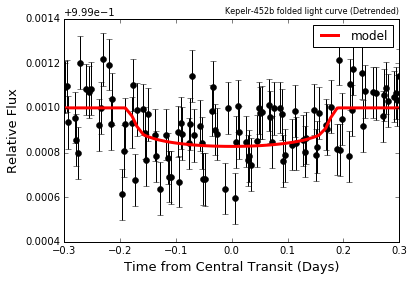

In [22]:
#Trim data to what to only transit +/- 0.3 
T = np.array(acc_t[W/2:-W/2]) # time -- 
E = np.array(acc_e[W/2:-W/2]) # error -- 
f = np.where((T>-0.30)&(T<0.30)) #np.where function will find the times of the given boundary +/-19

e_t = T[f] #event time 
e_f = Div[f] #event relative flux
e_e = E[f] #event errors

theta[4]=0.0 # since I have folded the lightcurve, purely for the sake of visualization,
             # i am going to set tau=0 to give a nice plot
# since i'm going to do a continuous line for my model, i need to sort the times first
P4 = 0

fmod = model(P0,P1,P2,P3,P4,np.sort(e_t)) #estimate batman model! 

#plot data! -- ploting log! 
plt.errorbar(e_t,(e_f),yerr=e_e,fmt='o',color='k')
plt.plot(np.sort(e_t),fmod,color='red',lw=3,label='model')
plt.legend()
plt.xlabel('Time from Central Transit (Days)',size=13)
plt.ylabel('Relative Flux',size=13)

plt.title('Kepelr-452b folded light curve (Detrended)',size=8,loc='right')



# Define MCMC Model

In [25]:
# We define a likelyhood -- and prior for normaly distributed data
def logpost(P0,P1,P2,P3,P4,e_f,e_t,e_e):
    """ Define logposterior of prior boundaries -- Returns logpost """""
    #Prior Boundaries: 
    pri_Romin = 0.00990  #lowest Rp/R* ratio 
    pri_Romax= 0.11 #0.1  #highest Rp/R* ratio Rp/R* 
    
    pri_Bmin=0 #minimum impact parameter
    pri_Bmax=1 #maximum impact parameter

    N=len(e_e) #length of data points
    #Define residuals:  Observed-Model
    Residual= (e_f) - model(P0,P1,P2,P3,P4,np.sort(e_t)) 
    
    #Condition: 
    if ((pri_Romin<P0) & (P0<pri_Romax)) & ((P2>pri_Bmin) & (P2<pri_Bmax)) :
        logpi=0 #log(pi) = 0 
        loglike = np.sum((Residual/e_e)**2) #estimating the loglike
        return loglike + logpi
    
    else: 
        logpi = 1000000000000   #return very large number    
        return logpi
        
#Define Metropolis hasting 
def Metropolis(tri_Ro,tri_B,in_Ro,in_B):
    """ Returns the probability that suggested trial will be accepted or rejected """
    DF1=logpost(tri_Ro,P1,tri_B,P3,P4,(e_f),e_t,e_e)
    DF2=logpost(in_Ro,P1,in_B,P3,P4,(e_f),e_t,e_e)
    P=np.e**(-.5 * (DF1-DF2)) #probability of jump
    return P

# MCMC Chain

In [26]:
# Parameters for set-up: 
Ro = []  #Rp/R*
B = []  # b -- impact parameter
Ltrial = []  
allRo = []  
allB = []  

#Define Jump size: 
Rojump = 0.0001 # Delta Rp/R* -- Jump size  0.0001 seems to converge at 10000 steps
Bjump = 0.22   # Delta Log(b) -- Jump size

#Define initial suggestions: 
in_Ro = 0.0128  # Initial suggested Rp/R*
in_B = 0.69  # Initial suggested b

#Define MCMC size:
MCMC = 10000  

#Begin loop 
i = 0
while True:
    # propose trial parameters 
    tri_Ro = np.random.normal(in_Ro, Rojump)
    tri_B = np.random.normal(in_B, Bjump)
    
    # if delta probs of trial/initial > 1, accept
    metrodecision = Metropolis(tri_Ro, tri_B, in_Ro,in_B) #take out the B's
  
    # Apply metropolis rule: 
    if  metrodecision >= 1:
        i = i + 1 
        # add trials to lists :
        Ro.append(tri_Ro)
        B.append(tri_B)
        Ltrial.append(logpost(tri_Ro, P1, tri_B, P3, P4, (e_f), e_t, e_e))
        # replace initials with trials:
        in_Ro = tri_Ro
        in_B = tri_B
        
    # if delta probs < 1, accept with probability  
    elif metrodecision < 1:
        # if random draw is less than probability, accept
        if np.random.uniform(0, 1) < Metropolis(tri_Ro, tri_B, in_Ro, in_B):
            i = i + 1 
            # add trials to lists :
            Ro.append(tri_Ro)
            B.append(tri_B)
            Ltrial.append(Metropolis(tri_Ro, tri_B, in_Ro, in_B))
            # replace initials with trials:
            in_Ro = tri_Ro
            in_B = tri_B
        # if random draw is more than probability, reject       
    if i == MCMC:
        break

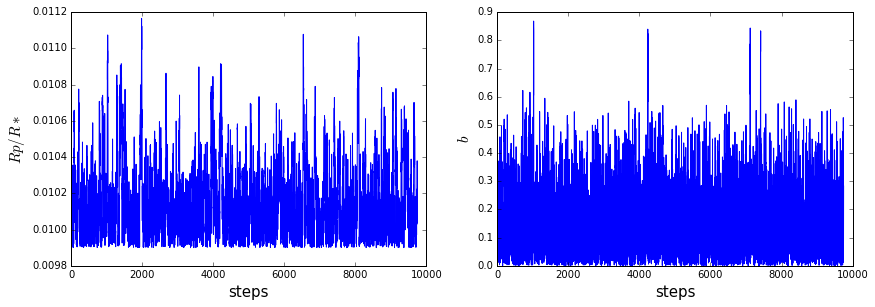

In [28]:
#plot mixing plots -- starting from the 250th indicies and up. 
plt.figure(figsize=(14,10))

plt.subplot(221)
plt.plot(Ro[250:])
plt.ylabel('$Rp/R*$',size=15)
plt.xlabel('steps',size=15)

plt.subplot(222)
plt.plot(B[250:])
plt.ylabel('$b$',size=15)
plt.xlabel('steps',size=15)

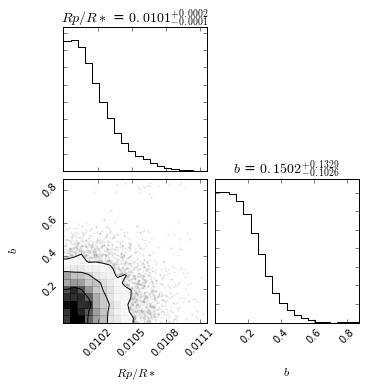

In [29]:
#Corner plot: 
import corner
dataE = np.column_stack((Ro[250:], B[250:]))
figure = corner.corner(dataE,smooth1d = True, show_titles = True, plot_contours = True,color='k', 
                   labels = ["$Rp/R*$", "$b$", "$log(ro)$"], title_kwargs={"fontsize": 14},
                   label_kwargs={"fontsize": 12},max_n_ticks=5,title_fmt='.4f')

In [30]:
# define functions to determine temperature and radius of planet Ethan et al. 

# get R_planet
def radi(Rrel, R_star):
    # takes in units of (1, R_sol)
    # outputs units of R_planet 
    R_sol = 6.957 * (10 ** 8)#m
    R_earth = 6.371008 * (10 ** 6)#m
    return Rrel * R_star * (R_sol / R_earth)

# simple luminosity calculation based on solar luminosity
def lum(R_star, T_eff): 
    # takes in units of (R_sol, Kelvin)
    # outputs units of solar luminosity
    T_eff_sol = 5772.0 #K # from wolfram
    R_sol = 1.0 #R_sols
    return (R_star / R_sol)** 2 * (T_eff / T_eff_sol)** 4

# stefan-blotzmann law
def sb_law(L, R_p):
    sb = 5.6704 * (10 ** -8) # W/(m**2 K**4) 
    L_sol = 3.848 * (10 ** 26)# W 
    R_earth = 6.371008 * (10 ** 6)#m
    A = 4 * np.pi * (R_p * R_earth) ** 2# m^2 
    return (np.pi / sb * L * L_sol / A) ** .25

def T_planet(T_star,R_star,a):
    Tp = T_star * np.sqrt((2*R_star)/a)
    return Tp

    

In [33]:
sp = np.loadtxt('/stellarPos.txt') # Stellar posterior samples, information about the orbiting star

#load variables: 
teff, logg, feh, mass, radius, logr, distance, av, logl, logw = sp[:,0],sp[:,1],
    sp[:,2],sp[:3],sp[:,4],sp[:,5], sp[:,6], sp[:,7], sp[:,8], sp[:,9]

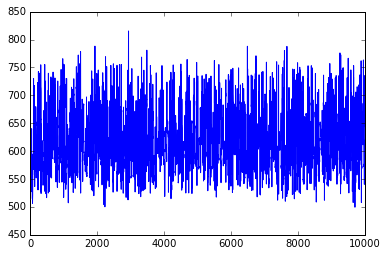

In [78]:
Rp = radi(Ro,radius[0:len(Ro)]) #earth radii
lp = lum(radius,teff)
Ts = sb_law(lp[0:len(Rp)],Rp)
Tp = T_planet(Ts,radius[0:len(Rp)],24561)
plt.plot(Tp)

In [36]:
#Physical conversions applying functions: 
Rp = radi(Ro,radius[0:len(Ro)])
lo = lum(radius[0:len(Ro)],teff[0:len(Ro)])
T_star = sb_law(lo,Rp)
rhostar = np.power(10.0,P1)
#a/R* calculation : 
aR = np.power( ( 6.67408e-11*(P3*86400.0)**2*rhostar )/( 3.0*np.pi ), 0.33333333 )
AR = radi(aR,radius[0:len(Ro)])
Tem = T_planet(T_star,radius[0:len(Ro)],24561)

In [ ]:
plt.figure(figsize=(7,5))

plt.axhspan(207.5, 320.4, color='green', alpha=0.7,label='Habitable Zone') #reported by Kipping et al. 

plt.scatter(np.arange(0,len(Tem),step=1),Tem,s=1)
plt.ylim(100,900)
plt.xlim(0,10000)
plt.xlabel('iterations',size=15)
plt.ylabel('Temperature [K]',size=15)


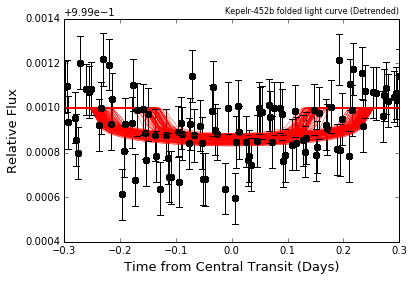

In [164]:
# select the first 500 indicies and plot the parameters
for i in range (0,500):
    fmod = model(Ro[i],P1,B[i],P3,P4,np.sort(e_t)) #estimate batman model!  
    plt.errorbar(e_t,(e_f),yerr=e_e,fmt='o',color='k')
    plt.plot(np.sort(e_t),fmod,color='red',lw=0.4)
    plt.xlabel('Time from Central Transit (Days)',size=13)
    plt.ylabel('Relative Flux',size=13)

    plt.title('Kepelr-452b folded light curve (Detrended)',size=8,loc='right')
    